In [1]:
import pandas as pd

docs = pd.read_csv('./datasets/provaxxers/provaxxers_processed.csv')
topics = pd.read_csv('./datasets/provaxxers/provaxxers_all_mpnet_base_v2_topics.csv')
docs = pd.concat([docs,topics], axis=1, ignore_index=False).drop(columns=["Unnamed: 0"])


favor = pd.read_json('./datasets/provaxxers/favor.json')
none = pd.read_json('./datasets/provaxxers/none.json')
favor = pd.DataFrame({'text': favor[0]})
none = pd.DataFrame({'text':none[0]})
favor['stance'] = 'favor'
none['stance']= 'none'
stances = pd.DataFrame()
stances = stances.append(favor)
stances = stances.append(none)

In [5]:
stances['stance'].value_counts()

favor    69261
none     43165
Name: stance, dtype: int64

<AxesSubplot:xlabel='stance', ylabel='count'>

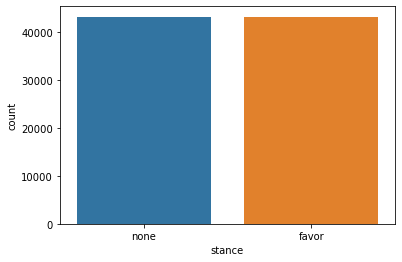

In [8]:
import seaborn as sns
from sklearn.utils import resample

mask = stances.stance=='favor'

df_favor = stances[mask]
df_none = stances[~mask]


df_downsample = resample(
    df_favor,
    replace=False,
    n_samples=len(df_none),
    random_state=42)

stances = pd.concat([df_none,df_downsample]).sort_index().reset_index().drop(columns=["index"]) 

sns.countplot(x=stances['stance'], label = 'count')

In [9]:
import sklearn
from sklearn.model_selection import train_test_split

train_data = stances

train_data["stance"] = train_data["stance"].replace(["favor", "none"],[0, 1])

X = train_data['text']
y = train_data['stance']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=333, test_size=0.3)

In [12]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

ModuleNotFoundError: No module named 'tensorflow'